# 第三小组 

成员以及贡献度排序（“（）”为同贡献度）：占子文 （吴晓山 兰思琪 冯伟珉 德娜勒安尼瓦）

In [137]:
import torch

print(torch.__version__)

2.5.1


#### 主要内容
* 一维和二维卷积操作；
* CNN架构的组成构件；
* 使用Pytorch实现深度CNN网络;
* 用于提升泛化性能的数据增强技术；
* 实现用于笑脸识别的CNN分类器；

如下图所示，CNN根据输入图像计算特征图(feature maps)， 其中每个元素来自输入图像中的局部像素块：

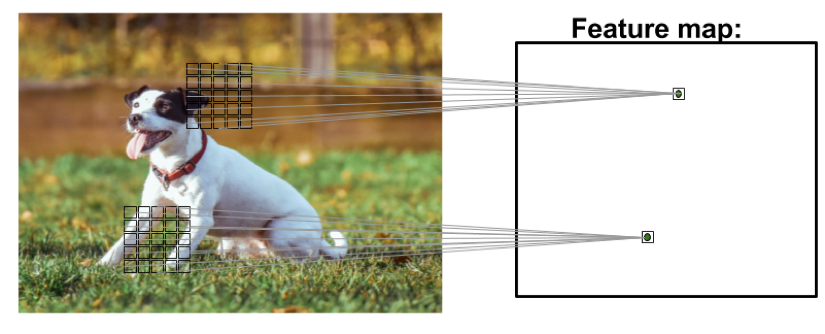

In [138]:
from IPython.display import Image

Image(filename=r'D:/Code/Python project/Machine Learning/机器学习课程/figures/ch14/figures/14_01.png', width=450)

其中，这个局部像素块被称为局部感受野(local receptive field). CNN在图像任务上非常出色，得益于如下两个方面：
* **稀疏连接(Sparse connectivity)**：特征图中的元素仅连接到一小块像素；
* **权重共享(Parameter sharing)**：对输入图像的不同块使用相同的权重；

卷积神经网络(Convolutional Neural Networks, CNN)是一种深度学习模型，它在图像和视频识别、分类以及分割任务重非常有效。

对于**稀疏连接**：在传统的全连接网络中，每个神经元都与前一层的所有神经元相连。这种连接方式参数数量非常多，计算复杂度很高。 CNN网络通过使用卷积层来实现稀疏连接。在卷积层中，每个神经元仅与输入数据的一个局部区域相连。这意味着每个卷积核(卷积核就是卷积层中的权重矩阵)只要覆盖输入数据的一个局部区域，而不是整个输入数据。所以这种局部连接方式减少了参数的数量，因为每个卷积核的参数数量远小于全连接层的参数数量，从而降低了计算量和存储需求.

对于**权重共享**：在卷积层中，同一个卷积核对应的权重在整个输入数据上是共享的。也就是说，同一个卷积核在不同的输入区域重复使用。`权重共享的优点是允许模型学习到局部特征的不变性，即相同的特征可以在图像的不同位置被检测到`。

通常，CNN由多个卷积层和子采样层(subsampling layers)组成，最后是一个或多个全连接层。而且，`子采样层通常又被称为池化层(Pooling layers)`,其不具有任何的可学习参数。卷积操作示意如下图：

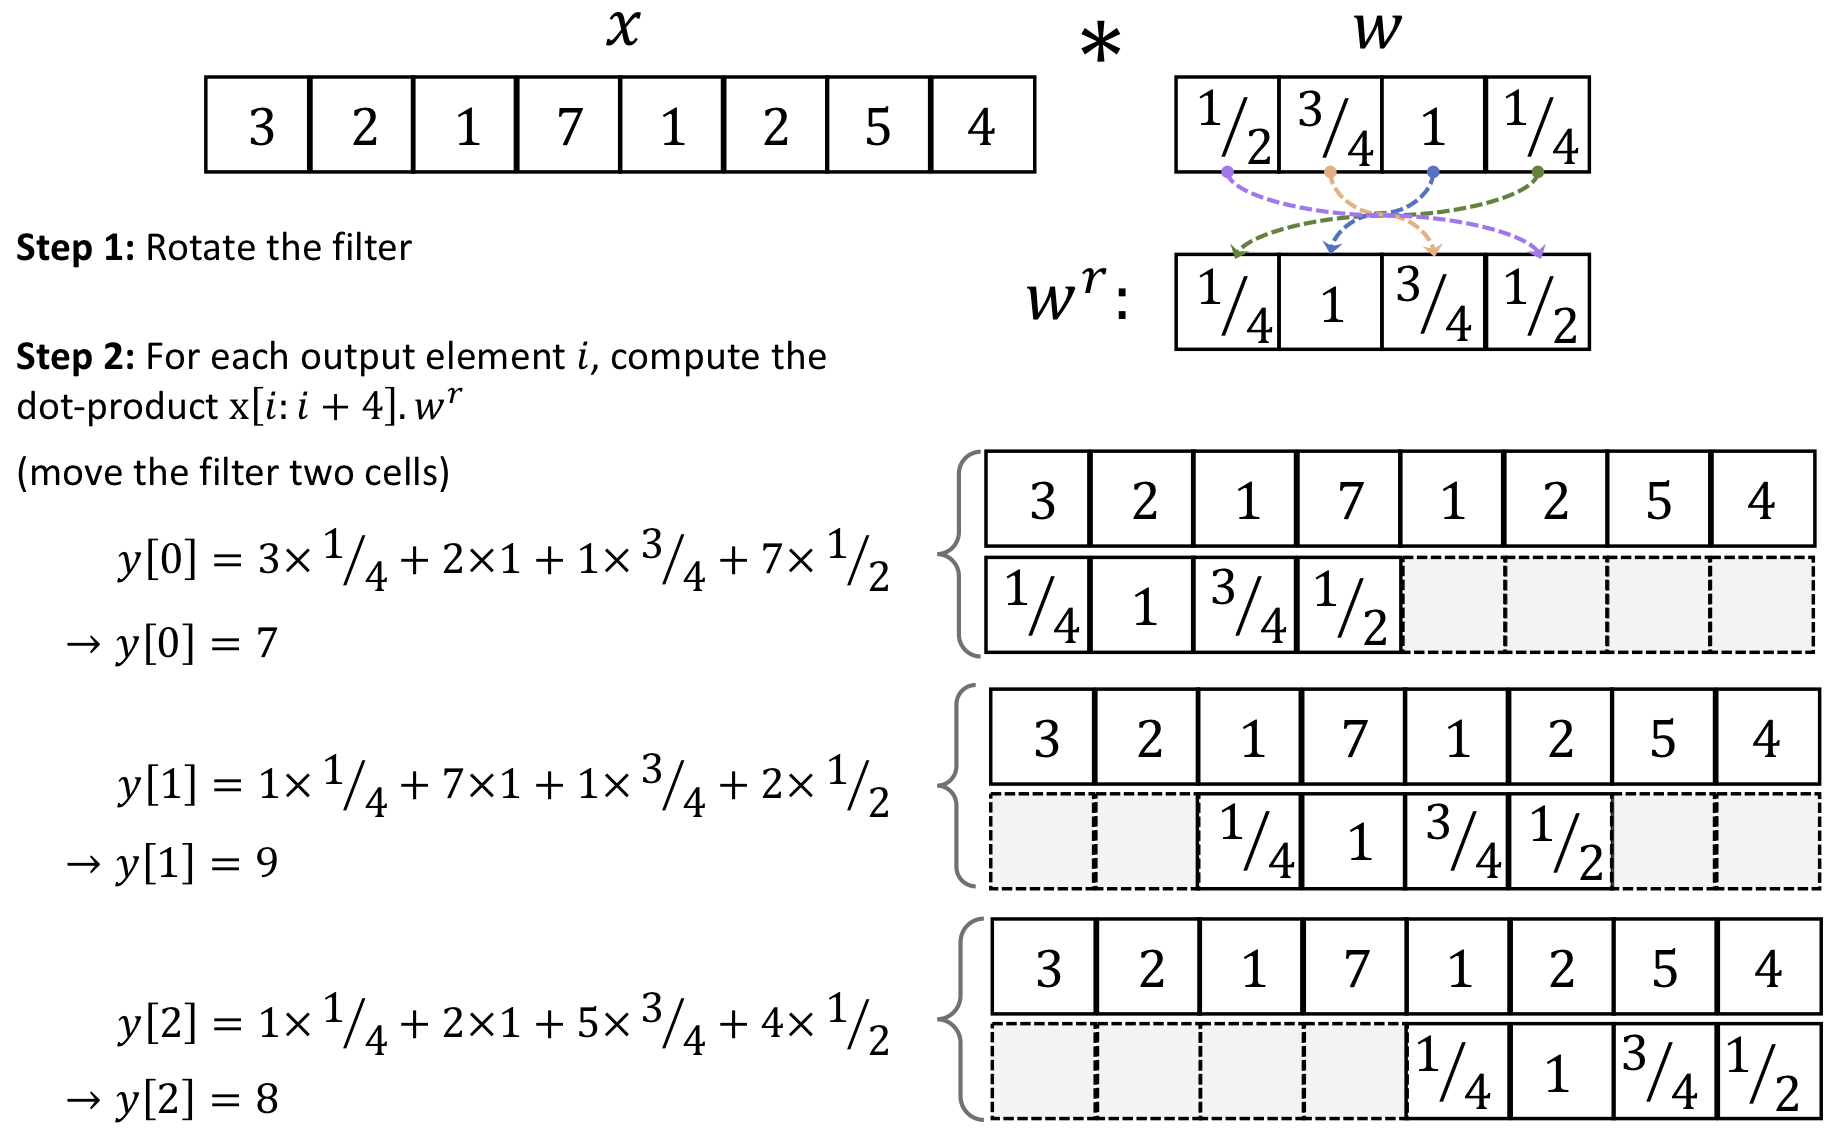

In [139]:
Image(filename=r'D:/Code/Python project/Machine Learning/机器学习课程/figures/ch14/figures/14_03.png', 
      width=450)

#### 利用Padding来控制输出特征图的大小

关于Padding的作用：

在神经网络中，特别是在卷积神经网络（CNN）中，padding（填充）有几个重要的原因：

1. **保持特征图的尺寸**：通过在输入数据的边缘添加零值（或其他值），我们可以控制特征图的尺寸。如果没有填充，卷积操作会使特征图的尺寸逐渐减少，这可能导致信息损失，尤其是在多个卷积层后。

2. **防止边缘效应**：卷积操作在边缘的像素受到更少的邻域像素的影响，可能导致边缘特征提取不充分。添加填充可以使卷积核在输入边缘处也能有足够的上下文，从而获得更好的特征学习。

3. **控制输出尺寸**：有时我们希望输出的特征图具有特定的空间尺寸。通过适当地添加填充，可以实现这一目标，而无需调整卷积核的大小或步幅。

4. **提高模型的表现**：在某些情况下，适当的填充可以改善模型的性能，使其更好地泛化到未见过的数据。

如下图是常见的3中Padding模式：

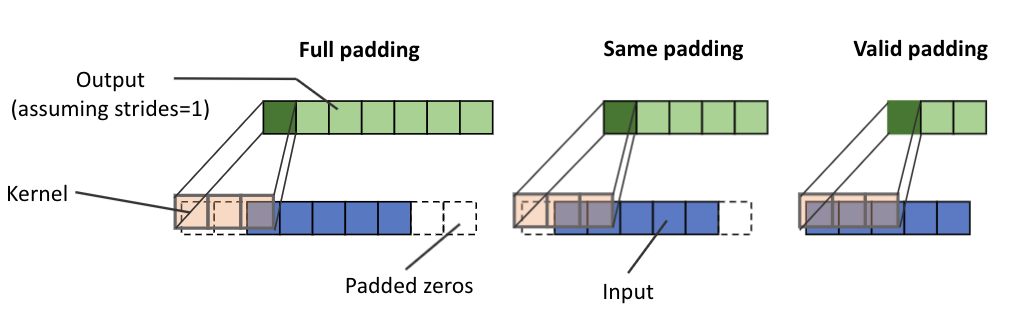

In [140]:
Image(filename=r'D:/Code/Python project/Machine Learning/机器学习课程/figures/ch14/figures/14_04.png', 
      width=450)

其中，same padding比较常用，这种方式的一个优点是保持了向量的大小(或者在图像任务中，保留了输入图像的高度和宽度).

valid padding相较于same padding的一个比较大的缺陷是：在具有许多层的NN中，张量的size将大幅减小，这可能会损害网络的性能。

full padding会导致输出大于输入大小，通常用于信号处理中，为了更好地最小化边界效应。

In [141]:
import numpy as np

# 原始数组
array = np.array([[1, 2], [3, 4]])

"""
pad_width=((1, 2), (2, 1)) 的解释：
第一维度 (行): (1, 2)
在行的前面填充 1 行零（在顶部）。
在行的后面填充 2 行零（在底部）。
第二维度 (列): (2, 1)
在列的前面填充 2 列零（在左侧）。
在列的后面填充 1 列零（在右侧）。
"""
padded_array = np.pad(array, pad_width=((1, 2), (2, 1)), mode='constant', constant_values=0)

print("填充后的数组：\n", padded_array)

填充后的数组：
 [[0 0 0 0 0]
 [0 0 1 2 0]
 [0 0 3 4 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


#### 确定卷积输出的大小

卷积的输出大小由移动滤波器的总次数决定. 这里假设输入向量的size为$n$, 卷积核size为$m$, 步长为$s$, 填充padding为$p$. 于是，输出结果$\boldsymbol{y=x*w}$的size为：

$$o=\left\lfloor\frac{n+2p-m}s\right\rfloor+1$$

#### 实现1维卷积

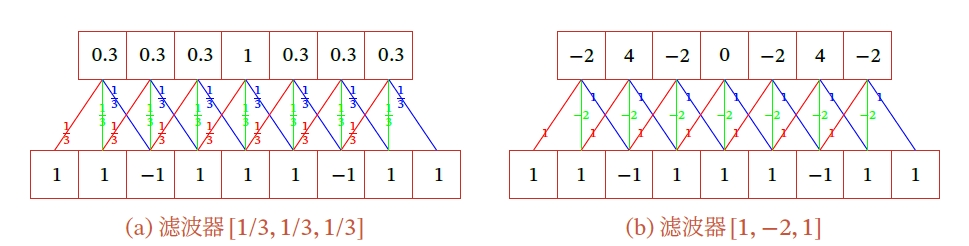

In [142]:
Image(r'D:/Code/Python project/Machine Learning/机器学习课程/figures/ch14/figures/Conv1d.png', 
      width=550)

In [143]:
import numpy as np

def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad])
        print(x_padded)
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot))) + 1, s):
        res.append(np.sum(x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)

# 调用函数测试.
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d Implementation:', conv1d(x, w, p=2, s=1))
print('Numpy Results:', np.convolve(x, w, mode='same'))

[0. 0. 1. 3. 2. 4. 5. 6. 1. 3. 0. 0.]
Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Results: [ 5 14 16 26 24 34 19 22]


#### 实现二维卷积

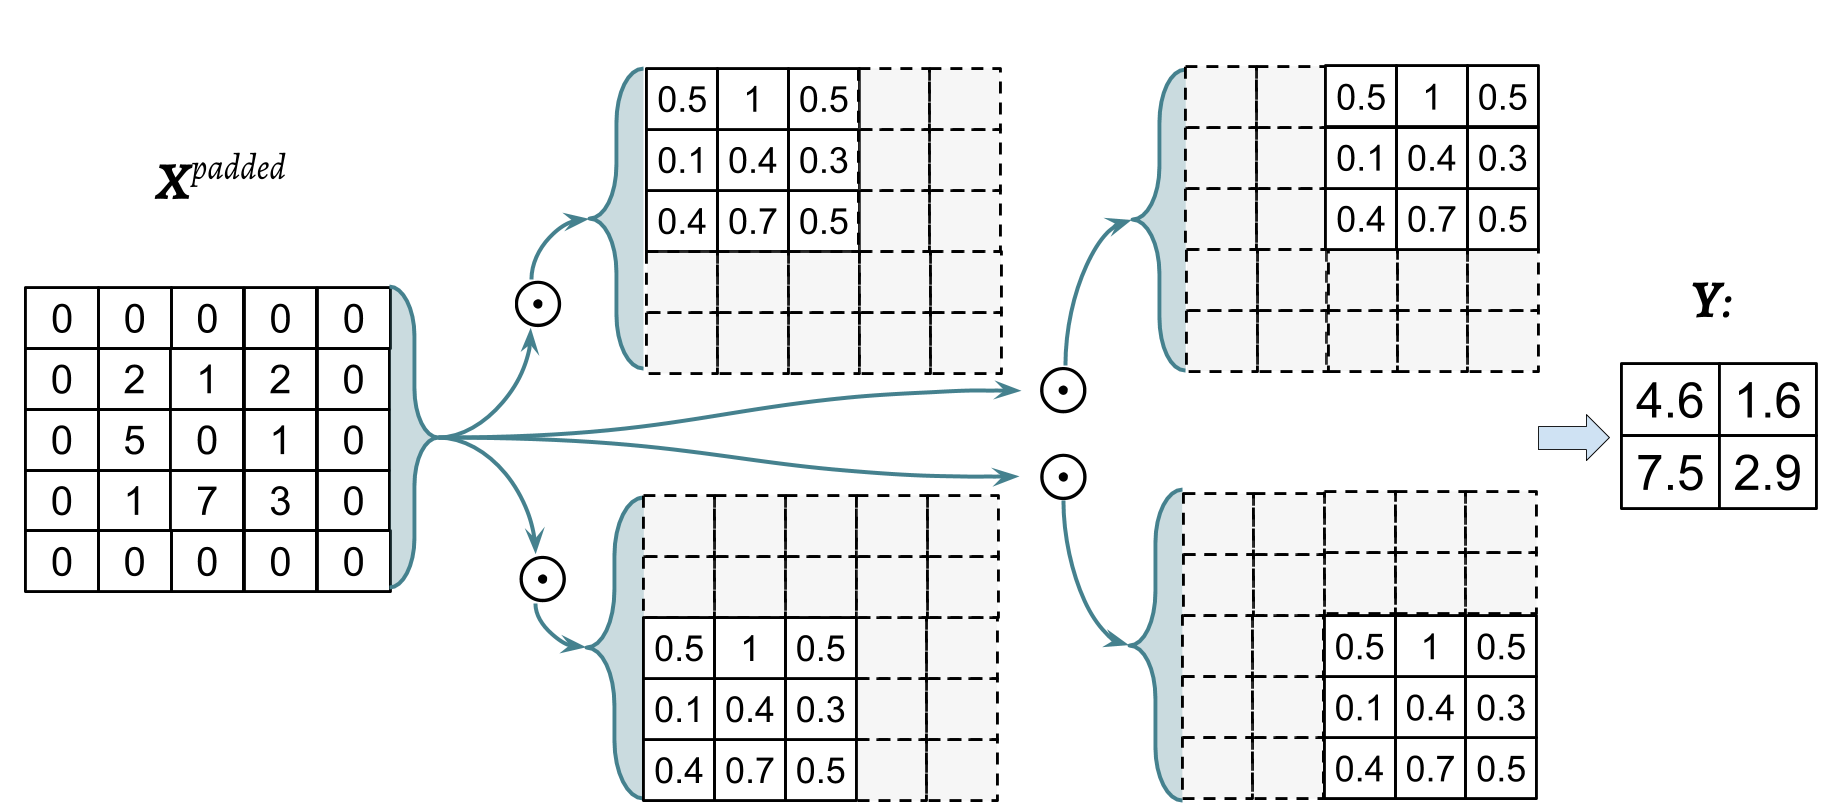

In [144]:
Image(filename=r'D:/Code/Python project/Machine Learning/机器学习课程/figures/ch14/figures/14_07.png', 
      width=450)

In [145]:
import numpy as np
import scipy.signal

def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1, ::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0], 
             p[1]:p[1]+X_orig.shape[1]] = X_orig
    print("X_padded:\n", X_padded)
    
    res = []
    for i in range(0, int((X_padded.shape[0] - W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0], j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return (np.array(res))

X = [[1, 3, 2, 4], 
     [5, 6, 1, 3], 
     [1, 2, 0, 2], 
     [3, 4, 3, 2]]
W = [[1, 0, 3], 
     [1, 2, 1], 
     [0, 1, 1]]

print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))

print('Scipy Results:\n', scipy.signal.convolve2d(X, W, mode='same'))

X_padded:
 [[0. 0. 0. 0. 0. 0.]
 [0. 1. 3. 2. 4. 0.]
 [0. 5. 6. 1. 3. 0.]
 [0. 1. 2. 0. 2. 0.]
 [0. 3. 4. 3. 2. 0.]
 [0. 0. 0. 0. 0. 0.]]
Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
Scipy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


#### 子采样层

在CNN中，子采样层通常应用于两种形式的池化操作：最大池化和平均池化(max-pooling and mean-pooling). 池化层通常由于$P_{n1\times n2}$表示，其中下表决定了执行最大或均值池化运算的邻域的大小. 示例如下：

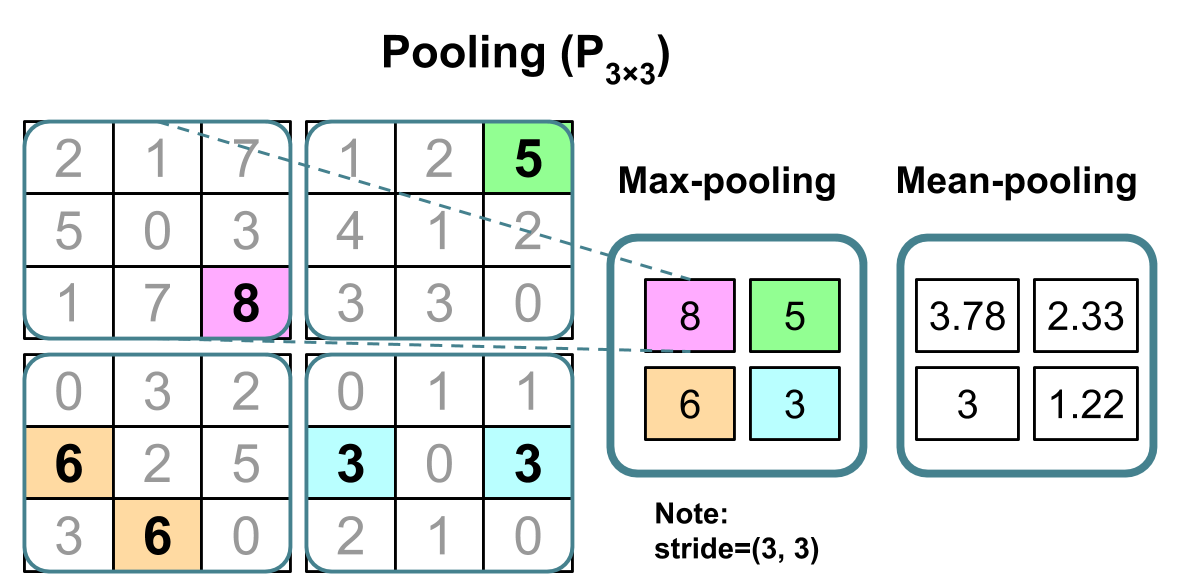

In [146]:
Image(filename=r'D:/Code/Python project/Machine Learning/机器学习课程/figures/ch14/figures/14_08.png', 
      width=450)

##### 池化操作的好处

*  **池化操作引入了局部不变性**，这意味着局部邻域中的小变化不会改变最大池化的结果，`有助于生成对输入数据中的噪声更具鲁棒性的特征`。  示例如下：

对矩阵$X_1, X_2$:

$$\begin{aligned}&\boldsymbol{X}_{1}=\begin{bmatrix}10&255&125&0&170&100\\70&255&105&25&25&70\\255&0&150&0&10&10\\0&255&10&10&150&20\\70&15&200&100&95&0\\35&25&100&20&0&60\end{bmatrix}\\\\&\boldsymbol{X}_{2}=\begin{bmatrix}100&100&100&50&100&50\\95&255&100&125&125&170\\80&40&10&10&125&150\\255&30&150&20&120&125\\30&30&150&100&70&70\\70&30&100&200&70&95\end{bmatrix}\end{aligned}$$

最大池化对应结果均为：
$$\xrightarrow{\max\text{pooling }P_{2\times2}}\begin{bmatrix}255&125&170\\255&150&150\\70&200&95\end{bmatrix}$$

* **池化操作减少了特征大小**，从而提高了计算效率。此外，减少特征数量也可以降低过拟合程度.

#### 实现CNN

In [147]:
# 读取彩色图像.
import torch
from torchvision.io import read_image

img = read_image(r'D:/Code/Python project/Machine Learning/机器学习课程/figures/ch14/R.jpg')

print('Image shape:', img.shape)            # [channels, image_height, image_width]
print('Number of channels:', img.shape[0])
print('Image data type:', img.dtype)
print('Matrix of the image:', img)

Image shape: torch.Size([3, 3024, 4032])
Number of channels: 3
Image data type: torch.uint8
Matrix of the image: tensor([[[  0,   0,   1,  ..., 167, 167, 167],
         [  0,   0,   1,  ..., 167, 167, 167],
         [  0,   0,   1,  ..., 167, 167, 167],
         ...,
         [ 86,  88,  89,  ..., 140, 140, 140],
         [ 93,  94,  94,  ..., 156, 157, 160],
         [ 86,  89,  88,  ..., 163, 165, 169]],

        [[171, 171, 172,  ..., 217, 217, 217],
         [171, 171, 172,  ..., 217, 217, 217],
         [171, 171, 172,  ..., 217, 217, 217],
         ...,
         [ 57,  60,  60,  ..., 106, 106, 106],
         [ 61,  65,  62,  ..., 120, 123, 126],
         [ 54,  57,  56,  ..., 127, 131, 135]],

        [[225, 225, 226,  ..., 242, 242, 242],
         [225, 225, 226,  ..., 242, 242, 242],
         [225, 225, 226,  ..., 242, 242, 242],
         ...,
         [ 43,  46,  46,  ...,  81,  81,  81],
         [ 48,  51,  49,  ...,  94,  96,  99],
         [ 41,  44,  43,  ..., 101, 103, 1

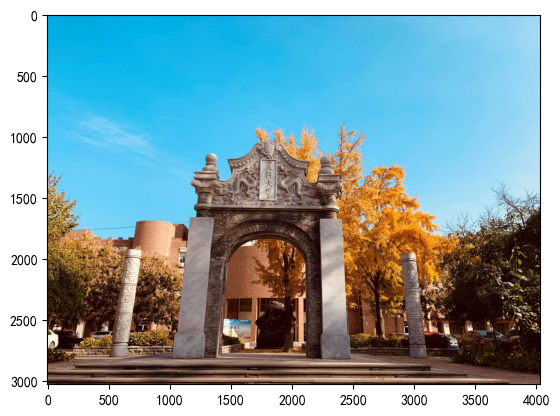

In [148]:
# 显示该示例图像.
import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))
plt.axis('on')
plt.show()

上述示例图像有3个通道,相较于单通道图像，这里需要分别对每个通道执行卷积操作，然后使用矩阵求和将结果相加。[一个在线示例](https://cs231n.github.io/assets/conv-demo/index.html).

对于给定的一个样本$\boldsymbol{X}_{n_{1}\times n_{2}\times C_{in}}$, 核kernel矩阵$\boldsymbol{W}_{m_{1}\times m_{2}\times C_{in}}$, 偏置value为$b$，total pre-activation计算过程如下：

$$Z^{Conv}=\sum_{c=1}^{C_{in}}\boldsymbol{W}[:,:,c]*\boldsymbol{X}[:,:,c]$$

$$Pre-activation: \boldsymbol{Z}=\boldsymbol{Z}^{Conv}+b_{c}$$

$$Feature map: \boldsymbol{A}=\sigma(\mathbf{\boldsymbol{Z}})$$

$\boldsymbol{A}$是特征图Feature map， 而一个卷积层中会有多个特征图。

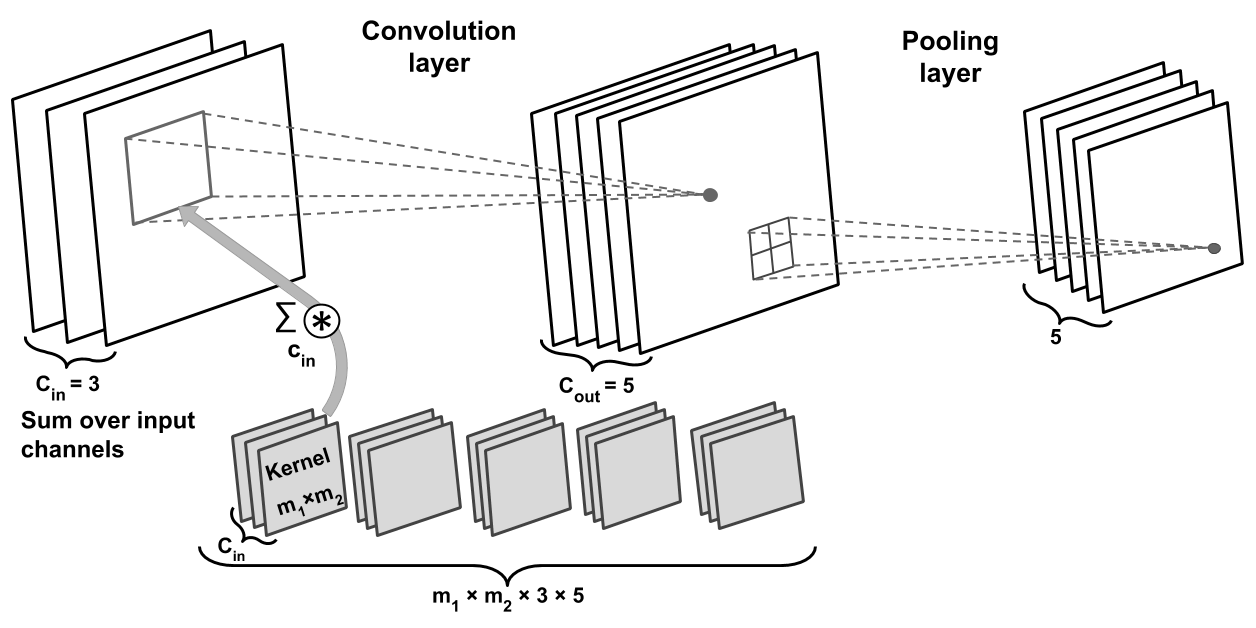

In [149]:
Image(filename=r'D:/Code/Python project/Machine Learning/机器学习课程/figures/ch14/figures/14_09.png', 
      width=450)

#### 使用L2正则化与Dropout方法正则化网络

In [150]:
# 对任意层添加L2惩罚.
import torch.nn as nn

loss_func = nn.BCELoss()
loss = loss_func(torch.tensor([0.9]), torch.tensor([1.0]))
l2_lambda = 0.001

conv_layer = nn.Conv2d(in_channels=3, 
                       out_channels=5, 
                       kernel_size=5)
l2_penalty = l2_lambda * sum([(p**2).sum() for p in conv_layer.parameters()])
loss_with_penalty = loss + l2_penalty


linear_layer = nn.Linear(10, 16)
l2_penalty = l2_lambda * sum([(p**2).sum() for p in linear_layer.parameters()])
loss_with_penalty = loss + l2_penalty

In [151]:
# 另外一种使用L2正则化的方法是将Pytorch优化器重的weight_decade参数设置为正值.
# 当使用SGD优化器的时候，L2 Regularization 和 权重衰减是等效的.
"""
optimizer = torch.optim.SGD(model.parmeters(), 
                            weight_decay=l2_penalty)
"""

'\noptimizer = torch.optim.SGD(model.parmeters(), \n                            weight_decay=l2_penalty)\n'

[Dropout](https://dl.acm.org/doi/abs/10.5555/2627435.2670313)通常应用于较高层的隐藏单元，其工作原理为在NN的训练阶段，每次迭代时都会随机丢弃一部分隐藏单元，概率为$p_{drop}$，它由用户指定，常见取值为$0.5$。

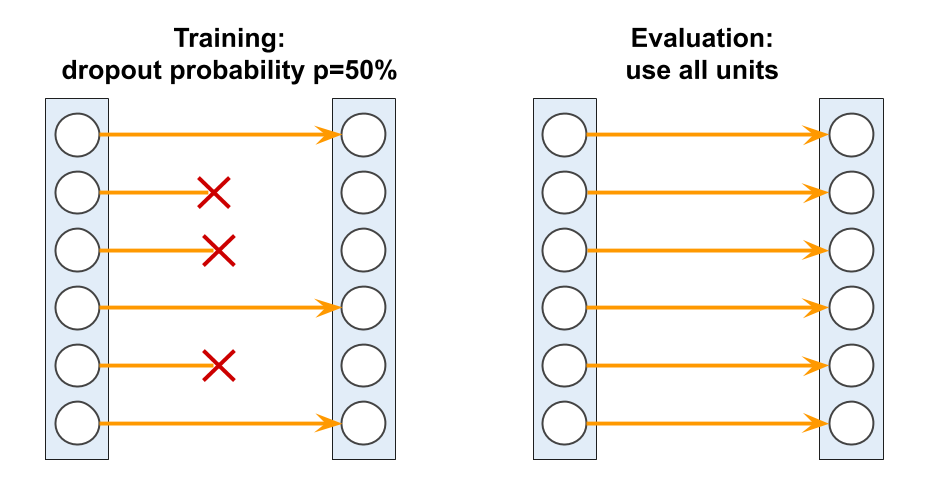

In [152]:
Image(filename=r'D:/Code/Python project/Machine Learning/机器学习课程/figures/ch14/figures/14_10.png', 
      width=450)

需要注意的是, 部分神经元仅仅在训练期间被随机丢弃，而对于评估(inference)阶段，所有隐藏单元必须处于活动状态，($p_{drop=0}$或者$p_{keep}=1$).

#### 损失函数

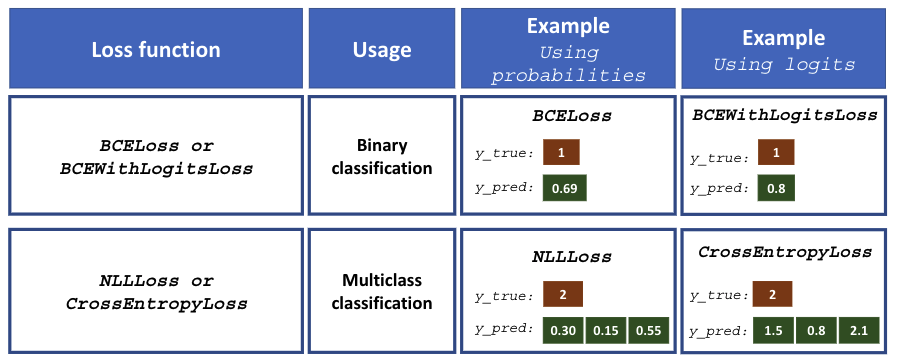

In [153]:
Image(filename=r'D:/Code/Python project/Machine Learning/机器学习课程/figures/ch14/figures/14_11.png', 
      width=450)

In [154]:
# 代码使用示例 Binary Cross-entropy.
logits = torch.tensor([0.8])
probas = torch.sigmoid(logits)

target = torch.tensor([1.0])
bce_loss_fn = nn.BCELoss()
bce_logits_loss_fn = nn.BCEWithLogitsLoss()

print(f'BCE (W Probas): {bce_loss_fn(probas, target):.4f}')
print(f'BCE (w Logits): {bce_logits_loss_fn(logits, target):.4f}')

BCE (W Probas): 0.3711
BCE (w Logits): 0.3711


In [155]:
# 代码使用示例 Categorical Cross-entropy.
logits = torch.tensor([[1.5, 0.8, 2.1]])
probas = torch.softmax(logits, dim=1)

target = torch.tensor([2])
cce_loss_fn = nn.NLLLoss()      # Negative Log Likelihood.
cce_logits_loss_fn = nn.CrossEntropyLoss()

print(f'CCE (w probas): {cce_loss_fn(torch.log(probas), target):.4f}')
print(f'CCE (w Logits): {cce_logits_loss_fn(logits, target):.4f}')

CCE (w probas): 0.5996
CCE (w Logits): 0.5996


#### 多层CNN架构

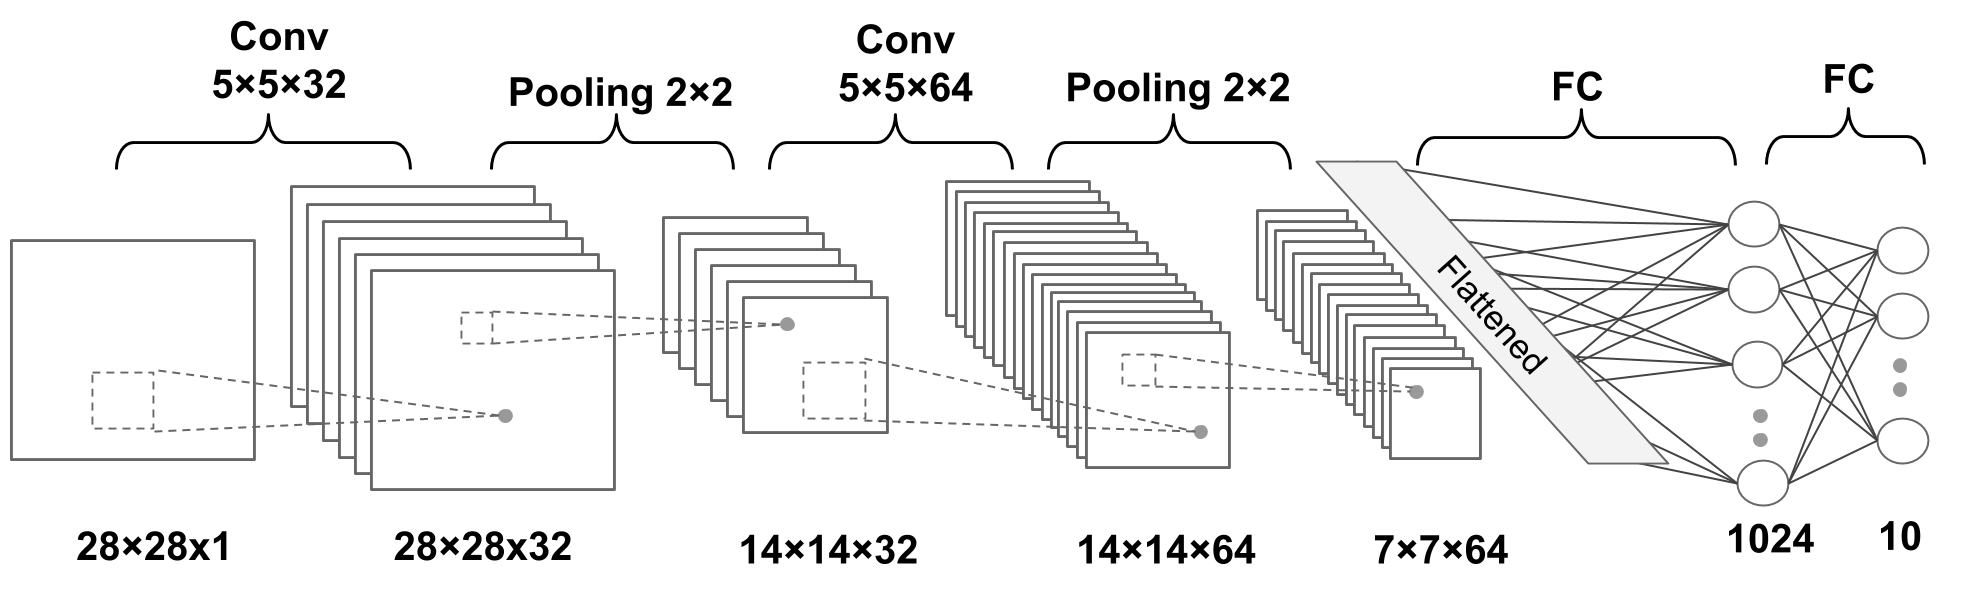

In [156]:
# 实现架构如下.
Image(filename=r'D:/Code/Python project/Machine Learning/机器学习课程/figures/ch14/figures/14_12.png', 
      width=450)

In [157]:
# 数据获取和预处理.
import torchvision
from torchvision import transforms
import seaborn as sns  # 用于更好的可视化
from sklearn.metrics import confusion_matrix, classification_report  

imag_path = r'D:/Code/Python project/Machine Learning/机器学习课程/datasets/MNIST'
transform = transforms.Compose([transforms.ToTensor()])

mnist_data = torchvision.datasets.MNIST(root=imag_path, 
                                        train=True, 
                                        transform=transform, 
                                        download=False) # download online， download=True.

In [158]:
# 划分出训练、验证、测试数据.
from torch.utils.data import Subset

mnist_valid_dataset = Subset(mnist_data, 
                             torch.arange(10000))
mnist_train_dataset = Subset(mnist_data, 
                             torch.arange(10000, len(mnist_data)))
mnist_test_dataset = torchvision.datasets.MNIST(root=imag_path, 
                                                train=False, 
                                                transform=transform, 
                                                download=False)

In [159]:
# 定义DataLoader.
from torch.utils.data import DataLoader

batch_size = 256
torch.manual_seed(3)

# 定义DataLoader
batch_size = 256
torch.manual_seed(3)
train_dl = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False)  # 新增测试集DataLoader


In [160]:
# 定义适用于MNIST的轻量化ResidualBlock（简化版）
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        # 简化卷积层参数，减少计算量
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        # 增加dropout防止过拟合（MNIST简单，轻微dropout即可）
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # 加入dropout
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out

# 调整后的ResNetMNIST（更适合MNIST）
class ResNetMNIST(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNetMNIST, self).__init__()
        self.in_channels = 8  # 初始通道数从16降为8，减少参数
        
        # 初始卷积层（适应28x28单通道输入，通道数减少）
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU(inplace=True)
        
        # 调整下采样策略：只进行1次下采样（避免特征图过小）
        # 通道数增长放缓：8→16→32（原16→32→64）
        self.layer1 = self._make_layer(block, 16, layers[0], stride=1)  # 保持28x28
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)  # 下采样到14x14
        self.layer3 = self._make_layer(block, 32, layers[2], stride=1)  # 保持14x14（原stride=2会到7x7，过小）
        
        # 全局平均池化（14x14→1x1）
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, num_classes)  # 输入维度随通道数减少
        
        # 初始化权重
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# 创建更轻量的模型（残差块数量从[2,2,2]减为[1,1,1]，总块数减少一半）
model = ResNetMNIST(ResidualBlock, [1, 1, 1])

# 后续的损失函数、优化器、训练部分不变，但建议调整学习率（网络变轻，可适当提高）
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 学习率从0.0006提高到0.001

# 选择设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model = model.to(device)

# 带早停机制的训练函数
def train(model, num_epochs, train_dl, valid_dl, patience=10, min_delta=0.0001):
    """ 
    带早停机制的训练函数
    参数: 
        patience: 允许多少个连续epoch没有改进
        min_delta: 被视为改进的最小变化量
    """
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    # 早停相关变量
    best_val_acc = 0.0
    patience_counter = 0
    early_stop_epoch = num_epochs
    
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()
        
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        # 验证阶段
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()
        
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} '
              f'val acc: {accuracy_hist_valid[epoch]:.4f}')
        
        # ===== 早停机制 =====
        # 检查验证准确率是否提升
        if accuracy_hist_valid[epoch] > best_val_acc + min_delta:
            best_val_acc = accuracy_hist_valid[epoch]
            patience_counter = 0
            # 保存最佳模型
            torch.save(model.state_dict(), 'best_resnet_model.pth')
        else:
            patience_counter += 1
            print(f'Early stopping: {patience_counter}/{patience} epochs without improvement')
        
        # 检查是否触发早停
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered at epoch {epoch+1}!')
            print(f'Best validation accuracy: {best_val_acc:.4f}')
            early_stop_epoch = epoch + 1
            break
    
    # 只返回实际训练的epoch数据
    return (loss_hist_train[:early_stop_epoch], 
            loss_hist_valid[:early_stop_epoch], 
            accuracy_hist_train[:early_stop_epoch], 
            accuracy_hist_valid[:early_stop_epoch])

Using device: cuda


In [161]:

# 开始训练，设置早停参数
torch.manual_seed(1)
num_epochs = 250
patience = 30  # 连续30个epoch验证准确率没有提升就停止
min_delta = 0.0001  # 验证准确率提升需要超过0.01%才视为有效改进

hist = train(model, num_epochs=num_epochs, train_dl=train_dl, 
             valid_dl=valid_dl, patience=patience, min_delta=min_delta)


Epoch 1 accuracy: 0.7111 val acc: 0.9397
Epoch 2 accuracy: 0.9590 val acc: 0.9648
Epoch 3 accuracy: 0.9731 val acc: 0.9666
Epoch 4 accuracy: 0.9784 val acc: 0.9786
Epoch 5 accuracy: 0.9826 val acc: 0.9830
Epoch 6 accuracy: 0.9848 val acc: 0.9841
Epoch 7 accuracy: 0.9872 val acc: 0.9841
Early stopping: 1/30 epochs without improvement
Epoch 8 accuracy: 0.9881 val acc: 0.9824
Early stopping: 2/30 epochs without improvement
Epoch 9 accuracy: 0.9889 val acc: 0.9841
Early stopping: 3/30 epochs without improvement
Epoch 10 accuracy: 0.9896 val acc: 0.9848
Epoch 11 accuracy: 0.9908 val acc: 0.9822
Early stopping: 1/30 epochs without improvement
Epoch 12 accuracy: 0.9917 val acc: 0.9862
Epoch 13 accuracy: 0.9917 val acc: 0.9841
Early stopping: 1/30 epochs without improvement
Epoch 14 accuracy: 0.9925 val acc: 0.9868
Epoch 15 accuracy: 0.9924 val acc: 0.9877
Epoch 16 accuracy: 0.9928 val acc: 0.9860
Early stopping: 1/30 epochs without improvement
Epoch 17 accuracy: 0.9929 val acc: 0.9896
Epoch 1

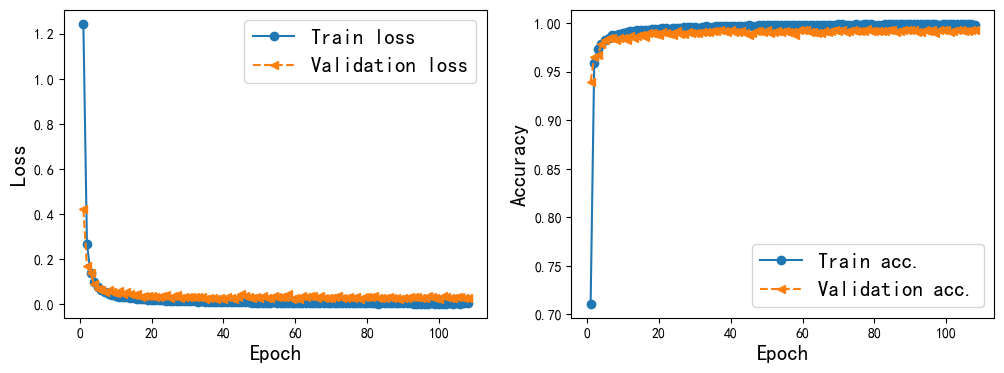

In [162]:
# 绘制学习曲线.
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用于显示中文标签

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()


开始在测试集上评估最佳模型...

测试集准确率: 0.9949 (9949/10000)

分类报告:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       1.00      1.00      1.00       892
           6       1.00      0.99      0.99       958
           7       1.00      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



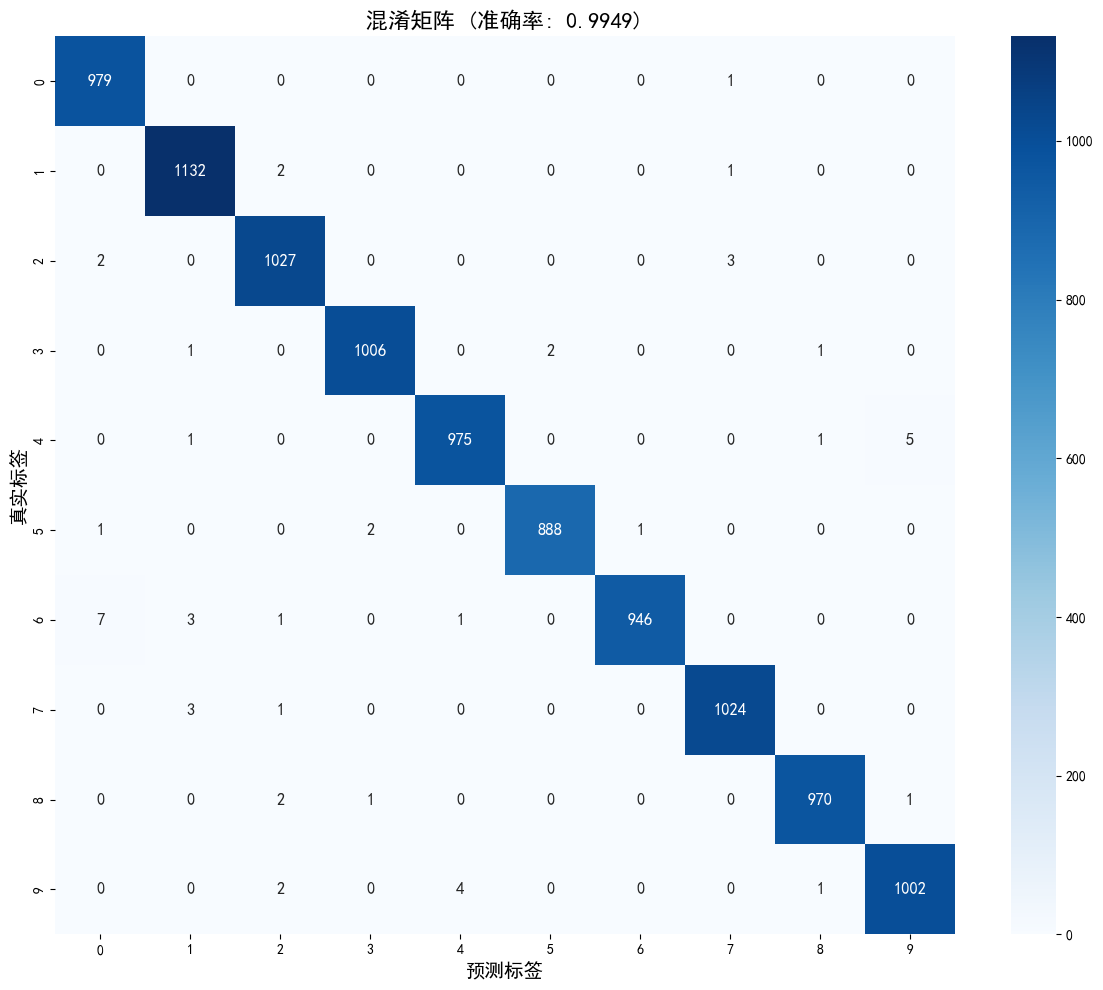


总错误样本数: 51


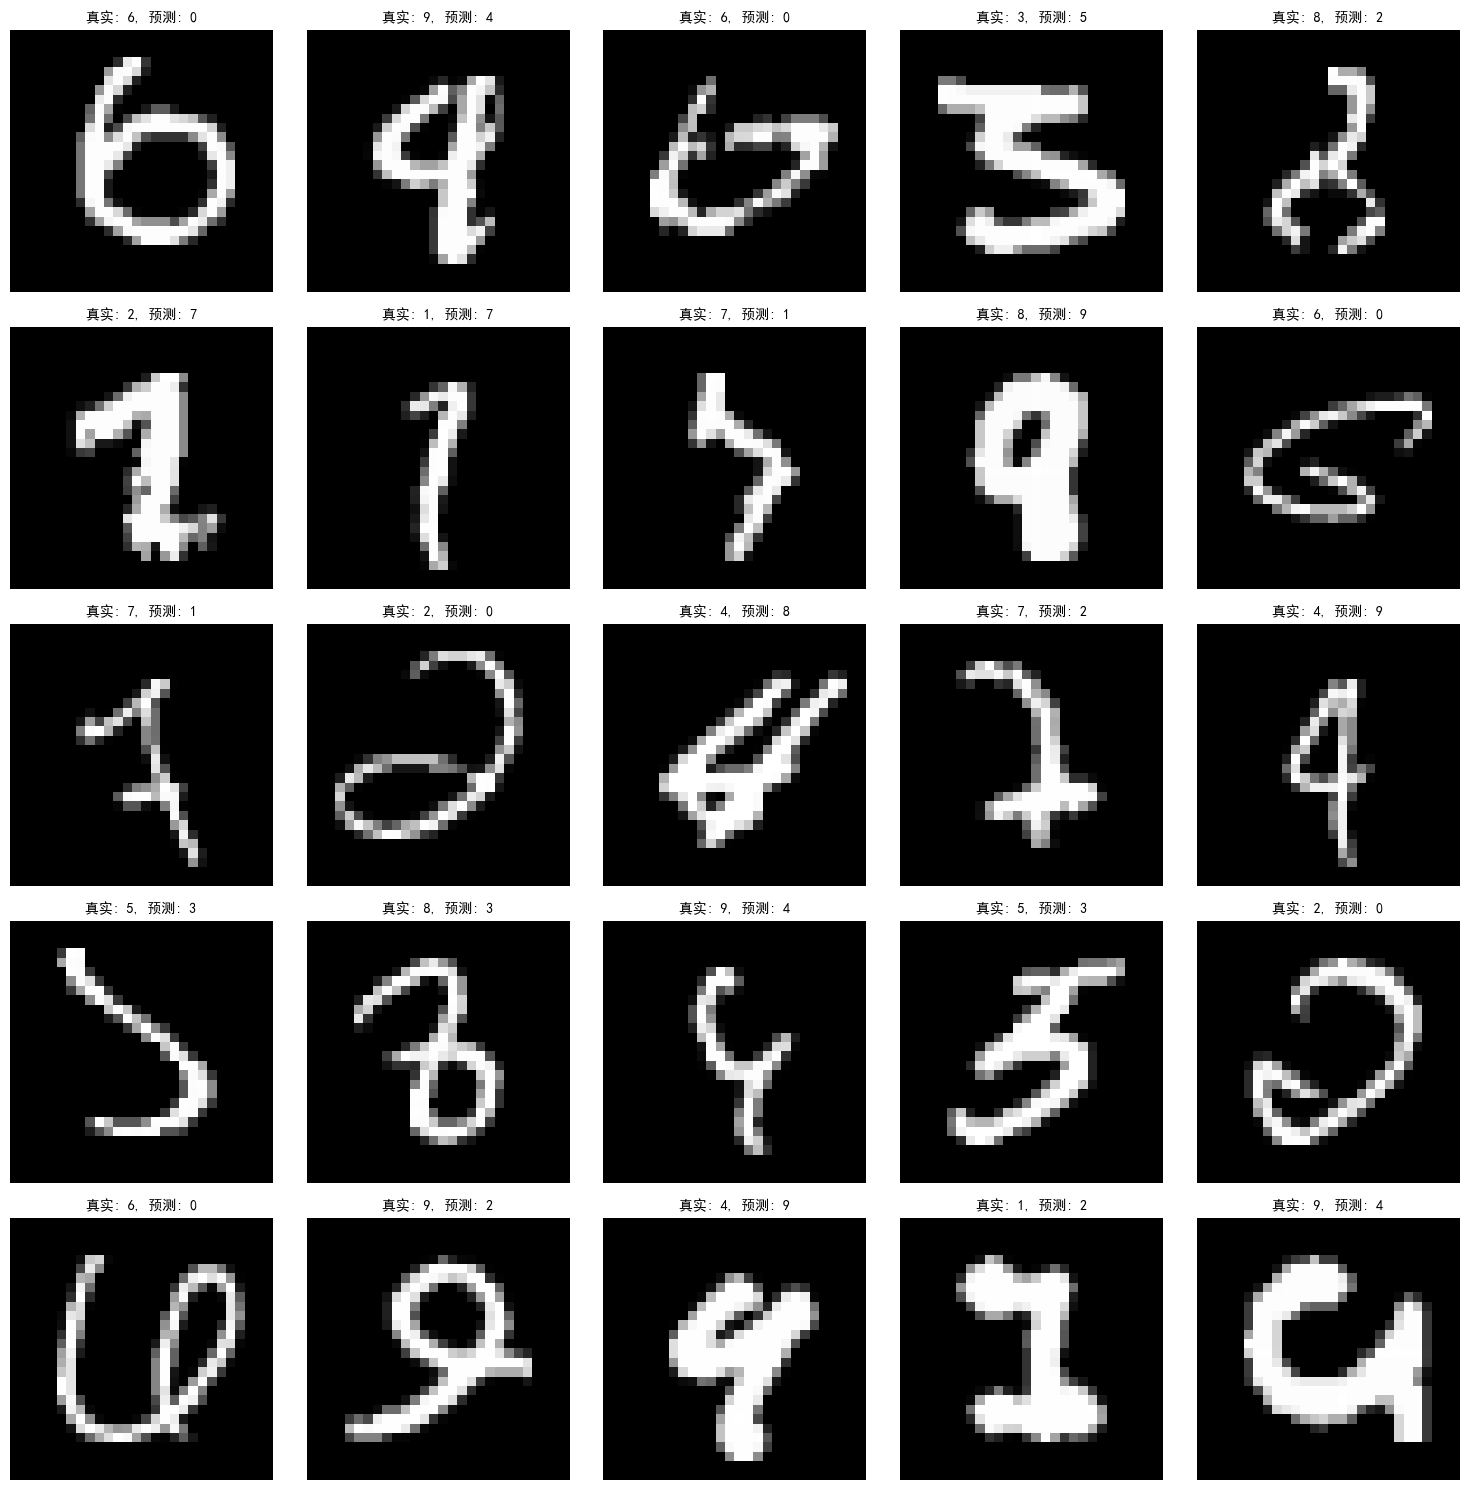


评估完成！结果已保存。


In [163]:
print("\n" + "="*50)
print("开始在测试集上评估最佳模型...")
print("="*50)

# 修复：安全加载模型
# 检查PyTorch版本是否支持weights_only参数
import torch
import pkgutil

if pkgutil.find_loader('torch') and hasattr(torch, 'serialization'):
    try:
        # 尝试使用weights_only参数（PyTorch 2.1+）
        model.load_state_dict(torch.load('best_resnet_model.pth', weights_only=True, map_location=device))
    except TypeError:
        # 旧版本PyTorch不支持weights_only参数
        model.load_state_dict(torch.load('best_resnet_model.pth', map_location=device))
else:
    model.load_state_dict(torch.load('best_resnet_model.pth', map_location=device))

model = model.to(device)
model.eval()    

# 收集预测结果和真实标签
all_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        pred = model(x_batch)
        predicted = torch.argmax(pred, dim=1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# 计算测试集准确率
test_accuracy = sum(1 for p, l in zip(all_preds, all_labels) if p == l) / len(all_labels)
print(f'\n测试集准确率: {test_accuracy:.4f} ({sum(1 for p, l in zip(all_preds, all_labels) if p == l)}/{len(all_labels)})')

# 生成分类报告
print("\n分类报告:")
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)]))

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 可视化混淆矩阵
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), 
            yticklabels=range(10),
            annot_kws={"size": 12})
plt.xlabel('预测标签', fontsize=14)
plt.ylabel('真实标签', fontsize=14)
plt.title(f'混淆矩阵 (准确率: {test_accuracy:.4f})', fontsize=16)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# 可视化一些错误分类的样本
errors = [(i, pred, label) for i, (pred, label) in enumerate(zip(all_preds, all_labels)) if pred != label]
print(f"\n总错误样本数: {len(errors)}")

# 显示前25个错误分类的样本
if errors:
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    axes = axes.ravel()
    
    for idx, (img_idx, pred, label) in enumerate(errors[:25]):
        # 获取原始图像
        img, _ = mnist_test_dataset[img_idx]
        img = img.squeeze().numpy()
        
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f'真实: {label}, 预测: {pred}', fontsize=10)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('misclassified_samples.png')
    plt.show()
else:
    print("没有错误分类的样本！模型完美！")

print("\n评估完成！结果已保存。")

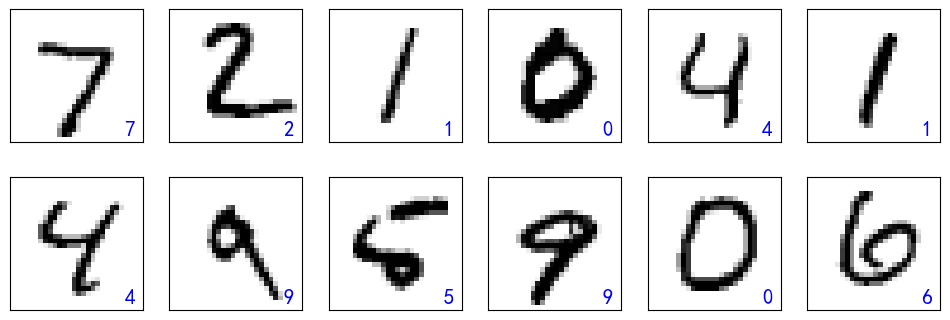

In [164]:
fig = plt.figure(figsize=(12, 4))
model.eval()  # 切换到评估模式
with torch.no_grad():
    for i in range(12):
        ax = fig.add_subplot(2, 6, i+1)
        ax.set_xticks([]); ax.set_yticks([])
        img = mnist_test_dataset[i][0]  # 直接获取1x28x28的张量
        # 增加批次维度并移到设备
        input_tensor = img.unsqueeze(0).to(device)
        pred = model(input_tensor)
        y_pred = torch.argmax(pred)
        ax.imshow(img.squeeze().numpy(), cmap='gray_r')  # 显示时挤压维度
        ax.text(0.9, 0.1, y_pred.item(), size=15, color='blue', 
                horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes)
plt.show()

### 方法 1：保存和加载整个模型

这种方法可以保存整个模型的结构和参数。使用 `torch.save()` 可以保存模型，使用 `torch.load()` 和 `model.load_state_dict()` 可以加载模型。

#### 保存模型
```python
import torch

# 假设 model 是你的模型
torch.save(model, 'model.pth')
```

#### 加载模型
```python
# 直接加载模型
loaded_model = torch.load('model.pth')
# 如果模型是在训练模式中，需要设置为 eval 模式
loaded_model.eval()
```

### 方法 2：保存和加载模型的状态字典

这是更常用的方法，因为它保存的是模型的参数，而不是整个模型的结构。这种方法更加灵活且节省空间。

#### 保存状态字典
```python
# 假设 model 是你的模型
torch.save(model.state_dict(), 'model_state_dict.pth')
```

#### 加载状态字典
```python
# 重新创建模型的实例
model = MyModel()  # MyModel 是你模型的定义类
model.load_state_dict(torch.load('model_state_dict.pth'))
# 需要设置为 eval 模式如果进行推断
model.eval()
```

### 总结
- 保存整个模型适合快速保存和加载，但不够灵活。
- 保存状态字典更推荐，特别是当模型结构可能发生变化时。它只保存模型的参数，使得可以在不同的环境中加载模型。  